In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [25]:
import torch

In [26]:
vocab_size = 10
time = 10
data = torch.randint(0,vocab_size,(1,time)).long()
data.shape

torch.Size([1, 10])

In [27]:
with open("data.txt") as f:
    data = f.read()
vocab = list(sorted(set(data)))
stoi = {v:i for (i,v) in enumerate(vocab)}
itos = {v:k for (k,v) in stoi.items()}
encode = lambda l:[stoi[i] for i in l]
decode = lambda l:''.join([itos[i] for i in l])

context_length = 10
n_embeddings = 10
n_heads = 2
x_train = []
y_train = []

for i in range(len(data) - context_length):
    x = data[i  : i+context_length]
    logits = data[i+1: i+1+context_length]
    x_train.append(encode(x))
    y_train.append(encode(logits))

In [28]:
x_train = torch.tensor(x_train)
y_train = torch.tensor(y_train)

In [29]:
from gpt import GPTConfig,GPT
model = GPT(
    GPTConfig(
        N=1,
        vocab_size=len(vocab),
        n_embeddings=100,
        context_length=context_length,
        n_heads=10,
        ff_scale=4
    )
)
optim = torch.optim.Adam(model.parameters())
(sum([p.numel() for p in model.parameters()]))

125265

In [30]:
losses = []

100%|██████████| 10/10 [00:00<00:00, 46.38it/s]


tensor(3.9516)

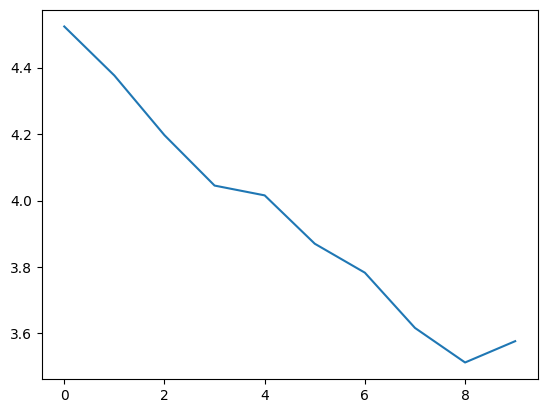

In [31]:
batch_size = 32
def get_batch(size):
    indices = torch.randint(len(data) - context_length, (size,))
    return (x_train[indices]), (y_train[indices])
import tqdm
for _ in tqdm.tqdm(range(10)):
    x, y = get_batch(batch_size)
    optim.zero_grad(set_to_none=True)
    logits, loss = model(x, y)
    loss.backward()
    optim.step()
    losses.append(loss.item())
import matplotlib.pyplot as plt
plt.plot(losses)
torch.mean(torch.tensor(losses[-100:]))

In [32]:
def generate(model,context,length):
    context = encode(context)
    print(context)
    if len(context)<context_length:
        context = ([stoi[" "]]*(context_length-len(context))) + context
    text = context
    while len(context)<length:
        d = text[-context_length:]
        logits ,_= model(torch.tensor([d]))
        logits = logits[:,-1,:]
        next = torch.multinomial(logits.softmax(-1),1)[0]
        text.append(next[0].item())
    return decode(text)
generate(model,"ff",100)

[44, 44]


'        ff\n  uVinRkendkPuSs ae df.VO& v e eigzZI e seSszas  ar,&B  \nsiean\n\nsn fe ffhi, fYeioCtzaZke '